# Merchant rating by de-anonymizing the data


### In this notebook:  
* Anonymized variables revealed.  
* Merchant rating generated.  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# Load merchants data
merchants = pd.read_csv("../input/merchants.csv")

# What is category_1 ?

We will start with`category_1` which will give us more idea about the other anonymized variables

In [2]:
merchants[merchants['category_1']=='Y'].head(10)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN
7,M_ID_d8ff08219e,16430,529,20,-0.057471,-0.057471,Y,E,E,NaN,1.000000,3,NaN,1.666667,6,NaN,1.500000,11,Y,-1,-1,NaN
9,M_ID_d2162ed113,112122,81,29,-0.057471,-0.057471,Y,E,E,NaN,1.000000,2,NaN,1.000000,2,NaN,1.000000,2,Y,-1,-1,NaN
11,M_ID_73487fed26,17123,427,27,-0.057471,-0.057471,Y,E,E,NaN,inf,3,NaN,inf,6,NaN,inf,12,Y,-1,-1,NaN
15,M_ID_c9855bf3e3,321,690,1,-0.057471,-0.057471,Y,E,E,NaN,1084.000000,3,NaN,3432.666667,6,NaN,5236.000000,12,Y,-1,-1,NaN
74,M_ID_64eacbe6fd,43601,222,21,-0.057471,-0.057471,Y,E,E,36169.11,146.333333,3,55775.50,233.000000,6,58389.45,255.444444,9,Y,-1,-1,NaN
111,M_ID_0039220eb3,35,836,5,-0.057471,-0.057471,Y,E,E,0.66,0.666667,3,0.66,0.666667,3,0.66,0.666667,3,Y,-1,-1,NaN
112,M_ID_0039220eb3,35,836,5,0.408530,0.408530,Y,C,D,1.17,1.109649,3,1.17,1.087939,6,1.19,0.997021,12,Y,-1,-1,NaN
287,M_ID_79c5ae42b3,7221,90,22,-0.057471,-0.057471,Y,E,E,499.26,37.333333,3,1360.90,286.666667,6,1800.55,417.111111,9,Y,-1,-1,NaN


From observation:
When `category_1` == Y:
1. `category_4`==Y
2. `city_id`, `state_id` are - 1
3. `category_2` is NaN

**Assumption**
1. `category_1` is for hiding the location or represents an online store  
2.`category_2` is also related to location eg. country  

The second assumption is very useful for us. But we need more proof.  

The following results prove assumption about  `category_2` by showing that for `merchant_id` with multiple observations, `category_2` differs only if `city_id` and `state_id` are different.

In [3]:
merchant_details_cols = ['merchant_id', 'merchant_group_id', 'merchant_category_id', 'subsector_id', 'category_1', 
                        'category_4', 'city_id', 'state_id', 'category_2']

merchant_details = merchants[merchant_details_cols]

# Delete duplicates
merchant_details = merchant_details.drop_duplicates()

u = merchant_details['merchant_id'].value_counts()
print("Number of merchant_id with more than 1 observation", len(u[u.values != 1]))
multi_obs_merchant_ids = u[u.values != 1].index
# get all rows with these merchant_ids from the table
multi_observ_table = merchant_details[merchant_details['merchant_id'].isin(multi_obs_merchant_ids)]
marchant_id_groups = multi_observ_table.groupby('merchant_id')

for n in list(marchant_id_groups.groups.keys()):
    a_merchant_id_group = marchant_id_groups.get_group(n)
    x = [col for col in a_merchant_id_group.columns if a_merchant_id_group[col].nunique()>1]
    print("ID =", n, '\tVariation in columns:', x)

Number of merchant_id with more than 1 observation 12
ID = M_ID_1802942aaf 	Variation in columns: ['merchant_group_id']
ID = M_ID_30340088f2 	Variation in columns: ['merchant_group_id']
ID = M_ID_42697d5d44 	Variation in columns: ['merchant_group_id']
ID = M_ID_645a6af169 	Variation in columns: ['merchant_group_id', 'merchant_category_id', 'city_id', 'state_id', 'category_2']
ID = M_ID_6464db3b45 	Variation in columns: ['merchant_group_id']
ID = M_ID_992a180b15 	Variation in columns: ['merchant_group_id']
ID = M_ID_bd49e37dda 	Variation in columns: ['merchant_group_id']
ID = M_ID_c2b9ac2ea4 	Variation in columns: ['merchant_group_id']
ID = M_ID_d123532c72 	Variation in columns: ['merchant_group_id']
ID = M_ID_dbbf07ebf0 	Variation in columns: ['merchant_group_id']
ID = M_ID_ebbdb42da6 	Variation in columns: ['merchant_group_id']
ID = M_ID_ef233cff26 	Variation in columns: ['merchant_group_id']


**`caregory_2` : Country**

### Create a Merchant Address variable 

From the above output, it is evident that a single `merchant_id` can be associated with more than one group, city & state. This is only possible if `merchant_id` is the (mapped/encrypted) used ID of the owner in Elo and an owner can list more than one of this shops in same or different city, state or country in his Elo account.  

Thus we are going to create a unique Id for the shop.  

Combine following columns to create a unique address to the shop.
```merchant_id, merchant_category_id, subsector_id, city_id, state_id, category_2```
We cannot use `merchant_group_id` since it is not in history & new transactions tables.

In [4]:
merchants['category_2'] = merchants['category_2'].fillna(0).astype(int)
merchants.loc[merchants['city_id'] == -1, 'city_id'] = 0
merchants.loc[merchants['state_id'] == -1, 'state_id'] = 0

In [5]:
merchant_address_id = merchants['merchant_id'].map(str)+ '_' + \
    merchants['merchant_category_id'].map(str) + '_'+ \
    merchants['subsector_id'].map(str) + '_'+ \
    merchants['city_id'].map(str) + '_'+ \
    merchants['state_id'].map(str) + '_'+ \
    merchants['category_2'].map(str)
    
merchants['merchant_address_id'] = merchant_address_id

In [6]:
merchants.drop(['merchant_id', 'merchant_category_id', 'subsector_id', 
                         'city_id', 'state_id', 'category_2'], axis=1, inplace=True)

merchants.head(10)

,merchant_group_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,merchant_address_id
0,8353,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,M_ID_838061e48c_792_9_242_9_1
1,3184,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,M_ID_9339d880ad_840_20_22_16_1
2,447,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,M_ID_e726bbae1e_690_1_0_5_5
3,5026,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,M_ID_a70e9c5f81_792_9_0_0_0
4,2228,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,M_ID_64456c37ce_222_21_0_0_0
5,20201,-0.057471,-0.057471,N,E,E,NaN,1.000000,3,NaN,3.666667,6,NaN,3.833333,12,Y,M_ID_a0915f62b5_87_27_160_21_5
6,33861,-0.057471,-0.057471,N,E,E,NaN,2.833333,3,NaN,4.833333,6,NaN,6.333333,12,N,M_ID_bfd41933db_792_9_60_16_1
7,16430,-0.057471,-0.057471,Y,E,E,NaN,1.000000,3,NaN,1.666667,6,NaN,1.500000,11,Y,M_ID_d8ff08219e_529_20_0_0_0
8,37179,-0.057471,-0.057471,N,E,E,NaN,115.000000,3,NaN,189.916667,6,NaN,197.000000,7,N,M_ID_c5b389236d_813_29_248_15_1
9,112122,-0.057471,-0.057471,Y,E,E,NaN,1.000000,2,NaN,1.000000,2,NaN,1.000000,2,Y,M_ID_d2162ed113_81_29_0_0_0


# How to use Sales and Purchase Lags?

**`avg_purchases_lag3` : Monthly average of transactions in last 3 months divided by transactions in last active month**  
If the reference is the year end, then this will be tha average of transactions in the last 3 months (Oct, Nov, Dec) (say 6 transactions in Oct, 6 in Nov, 6 in Dec, then avg transactions = 6) divided by number of transactions in the last active month (in this case suppose the merchant was active all three month - which is given in variable `active_months_lag3`- so num of transactions in Dec: 6). Here it is 6/6, thus the variable value is 1 (Steady -  no change in last month).   
Consider another example:    

### Processing to find rate of change

**Avg = 6,  last month=4**   
6/4 = **1.5**  (This is the value in the variable)  
We have to find the change in number of transactions in the last active month with respect to the average. So we need to reverse the fraction.   
1/1.5 = 0.6666666666666666  
Since we need to find the change (increased or decreased) we have to subtract the result from 1 (1 indicates 'No change')  
0.66 - 1 =  -0.3399999999999999  
Since it is negative, its a reduction in the number of transactions in the last month compared to average. In percentage:  
33% reduction  

**Avg = 6,  last month = 7**  
6/7 = **0.8571428571428571**  (This is the value in the variable)  
1/0.85714 =  1.1666705555685186  
1.16 -1 = 0.15999999999999992  
Positive, so increase  
16% increase  

**Avg = 6,  last month = 15**  
6/15 = **0.4**  
1/0.4 =  2.5  
2.5 - 1 =  1.5 (Positive; 1.5 > 1)  
more than 100% increase  

`avg_purchases_lag6` and `avg_purchases_lag6` evaluated over a period of 6 months (second half of the year if Dec is reference) and 12 months (second half of the year if Dec is reference).    

Same applies to sales lag for 3, 6 and 12 months where instead of number of trandsactions, revenue genereated is given.    

### Processing to compensate for not-active months  

active month lags give the number of months the account was active for the shop.  

Weather or not the merchant was active for all 3 months, `avg_purchases_lag3` & `avg_sales_lag3` are calculated based on the average of the whole 3 months, which will cause error if not compensated.  

Merchant B: Active 3 months  
m0 = 5, m1 = 6, m2 = 7 -> avg 6   
b = 6/7 = 0.857143 --> 16% increase  

Merchant A: Active 2 months  
m0 = 0, m1 = 5, m2 = 7 -> avg 4  
a = 4/7 = 0.57143 -> 75% increase  
Compensation: a * (3/2) = b  


### Rating

`most_recent_sales_range`:	Range of revenue (monetary units) in last active month --> A > B > C > D > E  
`most_recent_purchases_range`:	Range of quantity of transactions in last active month --> A > B > C > D > E    

A rating like the above variables is aimed with 5 values, so that the new rating and these variables can be compared. But unlike it, a integer rating is used so that mathematical operations can be performed.  

**High rating 1 to Low rating 5**   

Transactions: Inf < redu < 0%(steady)<incre< 100% <more than 100%    
no transactions in last month Inf ---> E -->5   
reduction x>= -0.99 and x < 0 --> D -->4    
equal to 0 --> x == 0 --> C -->3  
increase x > 0 and x <= 1  ---> B -->2  
more than 100% increase x > 1  --> A -->1  

Revenue: NaN or at loss(negative value) < redu < steady < increase < more than 100%    
no sales or at loss in last month Inf ---> E  
reduction x>= -0.99 and x < 0 --> D  
equal to 0 --> x == 0 --> C   
increase x > 0 and x <= 1  ---> B  
more than 100% increase x > 1  --> A  

In [7]:
def rating(x):
    if np.isfinite(x) or x < 0:
        x = (1/x) - 1
        
        if x>1:
            r = 1
        elif x <= 1 and x > 0:
            r = 2
        elif x == 0:
            r = 3
        elif x < 0 and x >= -1:
            r = 4
        else:
            r = 5
    else:
        r = 5
    return r
# end

In [8]:
merchants['avg_sales_lag3'] = (merchants['avg_sales_lag3'] / merchants['active_months_lag3']) * 3
merchants['avg_purchases_lag3'] = (merchants['avg_purchases_lag3'] / merchants['active_months_lag3']) * 3
merchants['avg_sales_lag6'] = (merchants['avg_sales_lag6'] / merchants['active_months_lag6']) * 6
merchants['avg_purchases_lag6'] = (merchants['avg_purchases_lag6'] / merchants['active_months_lag6']) * 6
merchants['avg_sales_lag12'] = (merchants['avg_sales_lag12'] / merchants['active_months_lag12']) * 12
merchants['avg_purchases_lag12'] = (merchants['avg_purchases_lag12'] / merchants['active_months_lag12']) * 12


merchants['avg_sales_lag3'] = merchants['avg_sales_lag3'].map(rating)
merchants['avg_purchases_lag3'] = merchants['avg_purchases_lag3'].map(rating)

merchants['avg_sales_lag6'] = merchants['avg_sales_lag6'].map(rating)
merchants['avg_purchases_lag6'] = merchants['avg_purchases_lag6'].map(rating)

merchants['avg_sales_lag12'] = merchants['avg_sales_lag12'].map(rating)
merchants['avg_purchases_lag12'] = merchants['avg_purchases_lag12'].map(rating)

merchants = merchants.drop(['active_months_lag3', 'active_months_lag6', 'active_months_lag12'], axis=1)

merchants.head(10)

,merchant_group_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,avg_sales_lag6,avg_purchases_lag6,avg_sales_lag12,avg_purchases_lag12,category_4,merchant_address_id
0,8353,-0.057471,-0.057471,N,E,E,5,4,5,4,5,4,N,M_ID_838061e48c_792_9_242_9_1
1,3184,-0.057471,-0.057471,N,E,E,5,4,5,4,5,4,N,M_ID_9339d880ad_840_20_22_16_1
2,447,-0.057471,-0.057471,N,E,E,5,4,5,4,5,4,N,M_ID_e726bbae1e_690_1_0_5_5
3,5026,-0.057471,-0.057471,Y,E,E,5,4,5,4,5,4,Y,M_ID_a70e9c5f81_792_9_0_0_0
4,2228,-0.057471,-0.057471,Y,E,E,5,2,5,1,5,1,Y,M_ID_64456c37ce_222_21_0_0_0
5,20201,-0.057471,-0.057471,N,E,E,5,3,5,4,5,4,Y,M_ID_a0915f62b5_87_27_160_21_5
6,33861,-0.057471,-0.057471,N,E,E,5,4,5,4,5,4,N,M_ID_bfd41933db_792_9_60_16_1
7,16430,-0.057471,-0.057471,Y,E,E,5,3,5,4,5,4,Y,M_ID_d8ff08219e_529_20_0_0_0
8,37179,-0.057471,-0.057471,N,E,E,5,4,5,4,5,4,N,M_ID_c5b389236d_813_29_248_15_1
9,112122,-0.057471,-0.057471,Y,E,E,5,4,5,4,5,4,Y,M_ID_d2162ed113_81_29_0_0_0


Combine the lag columns to create a single rating, each for sales and purchase:

In [9]:
merchants['sales_incrase_range'] = merchants[['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']].mean(axis=1)
merchants['purchase_incrase_range'] = merchants[['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']].mean(axis=1)

In [10]:
merchants['sales_incrase_range'] = merchants['sales_incrase_range'].round()
merchants['sales_incrase_range'] = merchants['sales_incrase_range'].astype(int)

merchants['purchase_incrase_range'] = merchants['purchase_incrase_range'].round()
merchants['purchase_incrase_range'] = merchants['purchase_incrase_range'].astype(int)

merchants = merchants.drop(['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12'], axis=1)
merchants = merchants.drop(['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12'], axis=1)

# Distribution of categories
print(pd.crosstab(merchants["sales_incrase_range"], merchants["most_recent_sales_range"],margins=True))

merchants.head(10)

most_recent_sales_range     A     B      C       D       E     All
sales_incrase_range                                               
1                           2    17    325    2752    3255    6351
2                         301  1569  12327   50037   47129  111363
3                         188  1159   8271   29922   42642   82182
4                         514  2292  13152   34764   84062  134784
5                           0     0      0       0      16      16
All                      1005  5037  34075  117475  177104  334696


,merchant_group_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,category_4,merchant_address_id,sales_incrase_range,purchase_incrase_range
0,8353,-0.057471,-0.057471,N,E,E,N,M_ID_838061e48c_792_9_242_9_1,5,4
1,3184,-0.057471,-0.057471,N,E,E,N,M_ID_9339d880ad_840_20_22_16_1,5,4
2,447,-0.057471,-0.057471,N,E,E,N,M_ID_e726bbae1e_690_1_0_5_5,5,4
3,5026,-0.057471,-0.057471,Y,E,E,Y,M_ID_a70e9c5f81_792_9_0_0_0,5,4
4,2228,-0.057471,-0.057471,Y,E,E,Y,M_ID_64456c37ce_222_21_0_0_0,5,1
5,20201,-0.057471,-0.057471,N,E,E,Y,M_ID_a0915f62b5_87_27_160_21_5,5,4
6,33861,-0.057471,-0.057471,N,E,E,N,M_ID_bfd41933db_792_9_60_16_1,5,4
7,16430,-0.057471,-0.057471,Y,E,E,Y,M_ID_d8ff08219e_529_20_0_0_0,5,4
8,37179,-0.057471,-0.057471,N,E,E,N,M_ID_c5b389236d_813_29_248_15_1,5,4
9,112122,-0.057471,-0.057471,Y,E,E,Y,M_ID_d2162ed113_81_29_0_0_0,5,4


# What is numerical_1 & numerical_2 ?

Data in histogram bins
 [334582     70     22      8      3      5      2      1      1      2]
Bins
 [-5.74706500e-02  1.81562086e+01  3.63698879e+01  5.45835672e+01
  7.27972465e+01  9.10109258e+01  1.09224605e+02  1.27438284e+02
  1.45651964e+02  1.63865643e+02  1.82079322e+02]
Mean: 0.008103109673922582


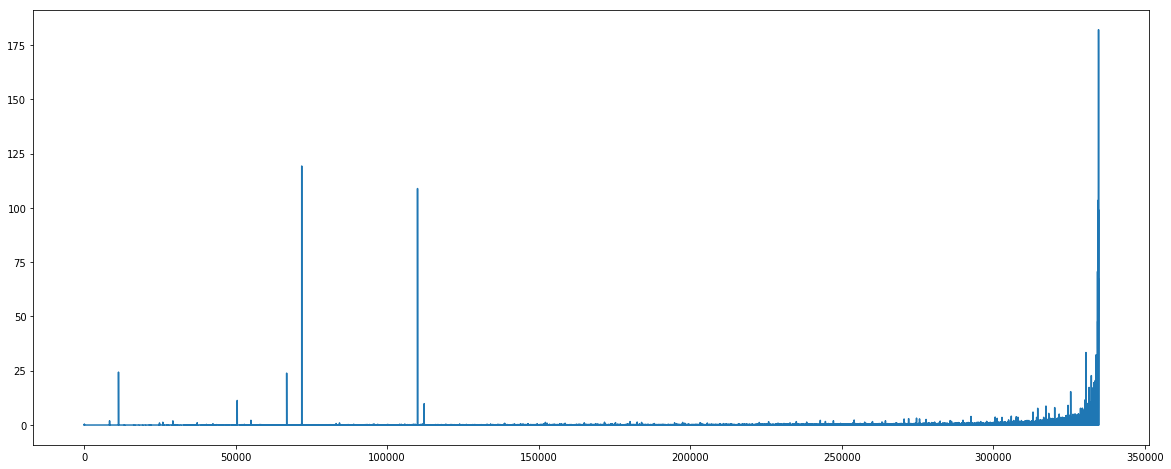

In [11]:
merchants['numerical_2'].plot.line(figsize=(20,8))

print("Data in histogram bins\n",np.histogram(merchants['numerical_2'])[0])
print("Bins\n",np.histogram(merchants['numerical_2'])[1])

print("Mean:", np.mean(merchants['numerical_2']))

Observation 1. Majority of points in the first bin  
Observation 2. Outliers with very high values compared to the mean

In [12]:
vc_numerical_1 = merchants['numerical_1'].value_counts()
vc_numerical_2 = merchants['numerical_2'].value_counts()
print("Value counts of 'numerical_1`")
vc_numerical_1.head(20)

Value counts of 'numerical_1`


-0.057471    228788
-0.047556     41528
-0.037641     15689
-0.027726      8297
-0.017811      5249
-0.007896      3739
 0.002019      2874
 0.011934      2249
 0.021849      1869
 0.031763      1642
 0.041678      1363
 0.051593      1220
 0.061508      1079
 0.071423       927
 0.081338       866
 0.091253       770
 0.101168       719
 0.111083       619
 0.120998       562
 0.130913       507
Name: numerical_1, dtype: int64

Observsation 3. Values are not continuous but are in various discrete levels, with many data points with same value

Let's investigate the outliers: Threshold for outliers is rounded to the first bin interval

Let's check how the other variables beheave in case of outliers.

In [13]:
outliers_numerical_1 = merchants.loc[merchants['numerical_1'] > 20, :]
outliers_numerical_2 = merchants.loc[merchants['numerical_2'] > 20, :]
outliers_numerical_1.head(10)

,merchant_group_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,category_4,merchant_address_id,sales_incrase_range,purchase_incrase_range
11364,35,25.671706,24.313364,N,A,A,Y,M_ID_508ecbdcde_650_29_158_15_1,4,4
66837,35,24.243960,23.847364,N,A,A,Y,M_ID_26d4fadb60_80_37_17_22_4,4,4
71810,35,136.827699,119.278318,N,A,A,Y,M_ID_b794b9d9e8_511_7_69_9_1,4,4
110011,35,128.628073,108.897413,N,A,A,Y,M_ID_ae9fe1605a_462_31_69_9_1,4,4
330524,35,36.597931,33.345842,N,B,B,Y,M_ID_63ece6c9c1_462_31_158_15_1,4,4
332300,35,23.123576,22.717065,Y,B,B,Y,M_ID_323617d0d5_511_7_0_0_0,4,4
333104,35,20.040040,19.435231,N,B,B,N,M_ID_b18d2bae5b_511_7_0_16_1,4,4
333616,35,20.555615,20.506041,N,B,B,N,M_ID_83ada27927_130_41_0_15_1,3,4
333857,35,22.746809,22.032936,N,A,A,Y,M_ID_235fba1cce_511_7_17_22_4,4,4
333867,35,32.136224,30.569669,N,A,A,Y,M_ID_5b9e251eea_511_7_137_19_3,4,4


Observation 4. Variables `most_recent_sales_range` & `most_recent_purchases_range` mostly have values is A or B. From description, this is very high range of sales and purchase. Most merchants have E or D, similar to very low values of numerical_1 & numerical_2.  

Conclusion: `numerical_1` & `numerical_2`are discrete values. The outliers are actually very high ratings which only few merchants have.  

Assumption: `numerical_1` & `numerical_2` are either related to or similar to `most_recent_sales_range` & `most_recent_purchases_range`.  

Action: **Discretize `numerical_1` & `numerical_2` by giving highest rating to maximum value in the variable and least rating to minimum. Following the convention used earlier, 1 is highest rating.**

In [14]:
# Map dict
vc_1 = merchants['numerical_1'].value_counts()
vc_1 = vc_1.reset_index()
vc_1 = vc_1.rename(columns={'index':'sales_rating'})
vc_1 = vc_1.sort_values(by='sales_rating', ascending=False)
vc_1 = vc_1.reset_index(drop=True)
vc_1 = vc_1.drop('numerical_1', axis=1)
vc_1 = vc_1.reset_index(drop=False)
vc_1 = vc_1.set_index('sales_rating')
vc_dict_1 = vc_1.to_dict()

vc_2 = merchants['numerical_2'].value_counts()
vc_2 = vc_2.reset_index()
vc_2 = vc_2.rename(columns={'index':'purchase_rating'})
vc_2 = vc_2.sort_values(by='purchase_rating', ascending=False)
vc_2 = vc_2.reset_index(drop=True)
vc_2 = vc_2.drop('numerical_2', axis=1)
vc_2 = vc_2.reset_index(drop=False)
vc_2 = vc_2.set_index('purchase_rating')
vc_dict_2 = vc_2.to_dict()

In [15]:
# Map numerical values of numerical_1 & numerical_2 with rating
# 1 being highest
merchants['numerical_1'] = merchants['numerical_1'].map(vc_dict_1['index'])
merchants['numerical_2'] = merchants['numerical_2'].map(vc_dict_2['index'])

merchants.head(10)

,merchant_group_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,category_4,merchant_address_id,sales_incrase_range,purchase_incrase_range
0,8353,953,946,N,E,E,N,M_ID_838061e48c_792_9_242_9_1,5,4
1,3184,953,946,N,E,E,N,M_ID_9339d880ad_840_20_22_16_1,5,4
2,447,953,946,N,E,E,N,M_ID_e726bbae1e_690_1_0_5_5,5,4
3,5026,953,946,Y,E,E,Y,M_ID_a70e9c5f81_792_9_0_0_0,5,4
4,2228,953,946,Y,E,E,Y,M_ID_64456c37ce_222_21_0_0_0,5,1
5,20201,953,946,N,E,E,Y,M_ID_a0915f62b5_87_27_160_21_5,5,4
6,33861,953,946,N,E,E,N,M_ID_bfd41933db_792_9_60_16_1,5,4
7,16430,953,946,Y,E,E,Y,M_ID_d8ff08219e_529_20_0_0_0,5,4
8,37179,953,946,N,E,E,N,M_ID_c5b389236d_813_29_248_15_1,5,4
9,112122,953,946,Y,E,E,Y,M_ID_d2162ed113_81_29_0_0_0,5,4


In [16]:
# Not found useful
merchants = merchants.drop(['category_1', 'category_4'], axis=1)

# Rating for Merchants

### Map to integers

`most_recent_sales_range` & `most_recent_purchases_range` are mapped to integers to perform mathematical operations


In [17]:
merchants['most_recent_sales_range'] = merchants['most_recent_sales_range']\
                                            .map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5})
merchants['most_recent_purchases_range'] = merchants['most_recent_purchases_range']\
                                            .map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5})

### Combine ratings

In [18]:
merchants['recent_activity_range'] = merchants['most_recent_sales_range'] + merchants['most_recent_purchases_range']
merchants['increase_in_activity_range'] = merchants['sales_incrase_range'] + merchants['purchase_incrase_range']
merchants['numerical_range'] = merchants['numerical_1'] + merchants['numerical_2']

merchants = merchants.drop(['most_recent_sales_range', 'most_recent_purchases_range',
                            'sales_incrase_range', 'purchase_incrase_range',
                            'numerical_1', 'numerical_2'], axis=1)

vc1 = merchants['recent_activity_range'].value_counts()
vc2 = merchants['increase_in_activity_range'].value_counts()
vc1.head(10)

10    141459
8      74146
9      67647
7      24147
6      19600
5       3502
4       2870
3        701
2        624
Name: recent_activity_range, dtype: int64

In [19]:
merchants['merchant_rating'] = merchants['recent_activity_range'] + merchants['increase_in_activity_range']
merchants = merchants.drop(['recent_activity_range', 'increase_in_activity_range'], axis=1)

merchants.head(10)

,merchant_group_id,merchant_address_id,numerical_range,merchant_rating
0,8353,M_ID_838061e48c_792_9_242_9_1,1899,19
1,3184,M_ID_9339d880ad_840_20_22_16_1,1899,19
2,447,M_ID_e726bbae1e_690_1_0_5_5,1899,19
3,5026,M_ID_a70e9c5f81_792_9_0_0_0,1899,19
4,2228,M_ID_64456c37ce_222_21_0_0_0,1899,16
5,20201,M_ID_a0915f62b5_87_27_160_21_5,1899,19
6,33861,M_ID_bfd41933db_792_9_60_16_1,1899,19
7,16430,M_ID_d8ff08219e_529_20_0_0_0,1899,19
8,37179,M_ID_c5b389236d_813_29_248_15_1,1899,19
9,112122,M_ID_d2162ed113_81_29_0_0_0,1899,19


### Delete Duplicate observations

Same merchant id with more than one `numerical_range, merchant_rating or merchant_group_id` 

Keep the highest rating and remove the duplicates.  

In [20]:
u = merchants['merchant_address_id'].value_counts()
print("Number of merchant_id with more than one observations:", len(u[u.values > 1]))
multi_obs_merchant_ids = u[u.values > 1].index 
multi_observ_table_merchants = merchants[merchants['merchant_address_id'].isin(multi_obs_merchant_ids)]
marchant_id_groups_m = multi_observ_table_merchants.groupby('merchant_address_id')

indices_to_drop = []
total = 0
for n in list(marchant_id_groups_m.groups.keys()):
    a_merchant_id_group_m = marchant_id_groups_m.get_group(n)
    size_of_group = a_merchant_id_group_m.shape[0]
    total += size_of_group
    size_after_dropped = size_of_group
    x = [col for col in a_merchant_id_group_m.columns if a_merchant_id_group_m[col].nunique()!=1]
    drop_this = []
    
    if not set(x).isdisjoint(['merchant_rating']): # 'merchant_rating' is different
        id_to_drop = a_merchant_id_group_m[a_merchant_id_group_m['merchant_rating']!=max(a_merchant_id_group_m['merchant_rating'])].index  
        a_merchant_id_group_m = a_merchant_id_group_m.drop(list(id_to_drop), axis=0)
        drop_this = drop_this + list(id_to_drop)
        size_after_dropped = a_merchant_id_group_m.shape[0]
    
    if size_after_dropped > 1 and not set(x).isdisjoint(['numerical_range']):
        id_to_drop = a_merchant_id_group_m[a_merchant_id_group_m['numerical_range']!=max(a_merchant_id_group_m['numerical_range'])].index
        a_merchant_id_group_m = a_merchant_id_group_m.drop(list(id_to_drop), axis=0)
        drop_this = drop_this + list(id_to_drop)
        size_after_dropped = a_merchant_id_group_m.shape[0]
        
    if size_after_dropped > 1 and not set(x).isdisjoint(['merchant_group_id']):
        id_to_drop = a_merchant_id_group_m[a_merchant_id_group_m['merchant_group_id']!=min(a_merchant_id_group_m['merchant_group_id'])].index
        a_merchant_id_group_m = a_merchant_id_group_m.drop(list(id_to_drop), axis=0)
        drop_this = drop_this + list(id_to_drop)
        size_after_dropped = a_merchant_id_group_m.shape[0]
        
    #print("Key=", n, "\tSize=", size_of_group, "\tDrop=", drop_this)
    indices_to_drop = indices_to_drop + drop_this
# end of for loop
a_merchant_id_group_m = marchant_id_groups_m.get_group('M_ID_9b0ef314cf_400_7_231_9_1') 
    
merchants = merchants.drop(indices_to_drop, axis=0)
merchants = merchants.reset_index(drop=True)
    
print("%d observations for %d merchant ids. %d duplicates deleted" %(total, 
                                                                     len(list(marchant_id_groups_m.groups.keys())), 
                                                                     len(indices_to_drop)))
merchants = merchants.drop(['merchant_group_id'], axis=1)

merchants.head(10)

Number of merchant_id with more than one observations: 40
102 observations for 40 merchant ids. 62 duplicates deleted


,merchant_address_id,numerical_range,merchant_rating
0,M_ID_838061e48c_792_9_242_9_1,1899,19
1,M_ID_9339d880ad_840_20_22_16_1,1899,19
2,M_ID_e726bbae1e_690_1_0_5_5,1899,19
3,M_ID_a70e9c5f81_792_9_0_0_0,1899,19
4,M_ID_64456c37ce_222_21_0_0_0,1899,16
5,M_ID_a0915f62b5_87_27_160_21_5,1899,19
6,M_ID_bfd41933db_792_9_60_16_1,1899,19
7,M_ID_d8ff08219e_529_20_0_0_0,1899,19
8,M_ID_c5b389236d_813_29_248_15_1,1899,19
9,M_ID_d2162ed113_81_29_0_0_0,1899,19


The merchant ids and ratings are converted to a dictionary for mapping the rating based on merchant id in the history and new transaction tables.

In [21]:
merchants = merchants.set_index('merchant_address_id')
merchants_dict = merchants.to_dict()

## Thank you for reading. :)